In [25]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import warnings
import sys,os
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0
from tqdm import tqdm

# Load and Aggregate based on SEACells

In [26]:
def get_dicts(ob):
    Ds = {}
    for s in sorted(set(ob['metacell'])):
        Ds[s]=[]
    for i,s in zip(ob.index, ob['metacell']):
        Ds[s].append(i)
    Dsi = dict(zip(ob.index, ob.metacell))
    return (Ds, Dsi)

In [27]:
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 90000, 200000, 1100000, 2600000, 6000000, 13000000]
Cell_number_dict={ts[i]:cells[i] for i in range(20)}

In [28]:
ob0 = pd.read_pickle(f'E105_metacells.pkl')
ob1 = pd.read_pickle(f'E115_metacells.pkl')

In [29]:
Ds0, Ds0i = get_dicts(ob0)
Ds1, Ds1i = get_dicts(ob1)

In [30]:
T = pd.read_pickle('Metacell_T.pkl')
M = T.values

D0n = dict(zip(T.index, range(len(T.index))))
D1n = dict(zip(T.columns, range(len(T.columns))))

In [31]:
D0_sc_to_inds = {}
for sc0 in tqdm(Ds0.keys()):
    D0_sc_to_inds[str(sc0)] = np.where(ob0.index.isin(Ds0[sc0]))[0]

100%|██████████████████████████████████████| 4573/4573 [00:41<00:00, 109.22it/s]


In [32]:
D1_sc_to_inds = {}
for sc1 in tqdm(Ds1.keys()):
    D1_sc_to_inds[str(sc1)] = np.where(ob1.index.isin(Ds1[sc1]))[0]

100%|███████████████████████████████████████| 7468/7468 [01:54<00:00, 65.08it/s]


In [33]:
# And reconstruct the full transition matrix from the SEACell associations, do the same thing for this

In [34]:
ct0s = sorted(set(ob0['cell_state']))
ct1s = sorted(set(ob1['cell_state']))

In [35]:
# Get proportonallity CT

In [36]:
def get_sub_CT_for_sc0_sc1(sc0, sc1, M, D0n, D1n, D0_sc_to_inds, D1_sc_to_inds, ob0, ob1, ct0s, ct1s, CT0):
    t = M[D0n[sc0], D1n[sc1]]
    if t>0:
        inds0 = D0_sc_to_inds[sc0]
        inds1 = D1_sc_to_inds[sc1]
        vc0 = ob0.cell_state.iloc[inds0].value_counts()
        vc1 = ob1.cell_state.iloc[inds1].value_counts()
        outer_product = np.outer(vc0, vc1)
        CTa = pd.DataFrame(outer_product, index=vc0.index, columns=vc1.index)
        CTa = CTa[ct1s].T[ct0s].T
        CTa = CTa/CTa.sum().sum() * t
        return(CTa)
    else:
        return(CT0)

In [38]:
sc0s = list(D0n.keys())
sc1s = list(D1n.keys())

In [39]:
CT0 = get_sub_CT_for_sc0_sc1(list(D0n.keys())[1], list(D1n.keys())[0], M, D0n, D1n, D0_sc_to_inds, D1_sc_to_inds, 
                             ob0, ob1, ct0s, ct1s, 'a')*0

def get_CT_for_scs(sc0, sc1s):
    CT = CT0.copy()
    for sc1 in sc1s:
        CT += get_sub_CT_for_sc0_sc1(sc0, sc1, M, D0n, D1n, D0_sc_to_inds, 
                                          D1_sc_to_inds, ob0, ob1, ct0s, ct1s, CT0)
    return CT

In [40]:
import os
num_workers = 10
import concurrent.futures

# This function is applied every time
def process_item(sc0):
    CT = get_CT_for_scs(sc0, sc1s)
    return(CT)

# I never change this
def parallel_process(items, num_workers):
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = list(tqdm(executor.map(process_item, items)))
    return list(results)
CTs = parallel_process(sc0s, num_workers=num_workers)

4573it [1:04:41,  1.18it/s]


In [41]:
CTc = CT0.copy()
for ct in CTs:
    CTc+=ct

<AxesSubplot:xlabel='cell_state', ylabel='cell_state'>

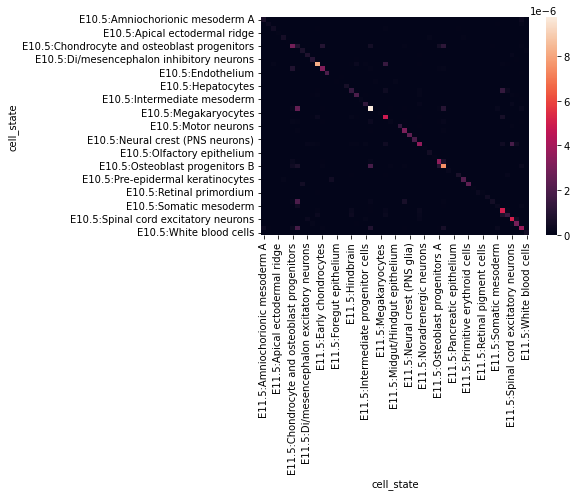

In [51]:
sns.heatmap(CTc)

In [52]:
# Check if sc1 contains Pancreas cells
pan_indices = set(np.where(ob1['cell_state'] == 'E11.5:Pancreatic epithelium')[0])

pull0 = pd.DataFrame(data=np.zeros(len(ob0)), index=ob0.index, columns=['c'])

def get_pull_of_sc1(sc1, D0_sc_to_inds, D1_sc_to_inds, pan_indices, ob0, M, sc0s, D0n, D1n, pull0):
    inds1 = D1_sc_to_inds[sc1]
    inters = set(inds1)&pan_indices

    if len(inters)>0:
        prop = len(inters)/len(inds1)
        p = np.zeros(len(ob0))
        for sc0 in sc0s:
            t = M[D0n[sc0], D1n[sc1]]
            if t>0:
                p[D0_sc_to_inds[sc0]]=t*prop
        pull = pd.DataFrame(data=p, index=ob0.index, columns=['c'])

    else:
        pull = pull0
    return(pull)

pull = pull0.copy()
for sc1 in tqdm(sc1s):
    pull += get_pull_of_sc1(sc1, D0_sc_to_inds, D1_sc_to_inds, pan_indices, ob0, M, sc0s, D0n, D1n, pull0)
pull

100%|█████████████████████████████████████| 7468/7468 [00:01<00:00, 3957.04it/s]


,c
sci3-me-001.GAGGAACTTAATACCATCC,1.656080e-45
sci3-me-001.CTACGGCATGCTAACTTGC,0.000000e+00
sci3-me-001.ATCTGATGATGCTAACTTGC,7.315567e-23
sci3-me-002.ACAGGTATTTTCGGCCTTAC,2.257748e-15
sci3-me-002.AGAACTCCTGGTATCCGCC,6.996039e-28
...,...
sci3-me-760.AGGCATCATTCTTGCCGAC,6.351277e-34
sci3-me-760.GGTTCGAGTTCTTGCCGAC,1.434072e-39
sci3-me-760.AAATCGTTCTCGTAGTTACC,4.238438e-26
sci3-me-760.TAGGAAGGTTCTTGCCGAC,5.216753e-13


In [53]:
pull.to_pickle('Pancreas_pull_metacells.pkl')

In [54]:
CTc.to_pickle('CT_metacells.pkl')